Takes in .AWD, sleep log if it exists, calendar, and spits out some pretty pictures

In [2]:
import os,sys,inspect
current_dir = os.path.dirname(os.path.abspath(inspect.getfile(inspect.currentframe())))
parent_dir = os.path.dirname(current_dir)
sys.path.insert(0, '/data/MoodGroup/actigraphy/gavi/actigraPy') 

import actigraPy.actigraPy as act
import importlib
import numpy as np
import pandas as pd
from datetime import datetime
from datetime import timedelta

/data/MoodGroup/actigraphy/gavi/actigraPy/actigraPy/actigraPy.py:23: MatplotlibDeprecationWarning: 
The matplotlib.backends.tkagg module was deprecated in Matplotlib 3.0 and will be removed in 3.2.
  import matplotlib.backends.tkagg as tkagg


## Subject and directory info

In [9]:
# data and log directories
sub = 'test'
sub_long = 'TEST'

out_dir = '/data/MoodGroup/actigraphy/gavi/actigraPy/data' #output directory
data_dir = '/data/MoodGroup/actigraphy/gavi/actigraPy/data' 

if not os.path.exists(out_dir):
    os.mkdir(out_dir)


In [10]:
fn = {}
#.AWD
awd_fn = os.path.join(data_dir, '%s.AWD'%sub_long)
#sleeplog
fn['cal']= os.path.join(data_dir, '%s_calendar_log.xls'%sub_long)
#calendar
fn['log'] = os.path.join(data_dir, '%s_sleeplog.xls'%sub_long)
logs = []

if os.path.isfile(awd_fn):
    for name in fn.keys():
        if os.path.isfile(fn[name]):
            print("%s has %s file at %s"%(sub,name,fn[name]))
            logs.append(fn[name])
        else:
            print("no " + name)
            fn[name] = ''
else:
    print("DO NOT CONTINUE!! THERE IS NO AWD FILE")

test has cal file at /data/MoodGroup/actigraphy/gavi/actigraPy/data/TEST_calendar_log.xls
test has log file at /data/MoodGroup/actigraphy/gavi/actigraPy/data/TEST_sleeplog.xls


### Make Mtimes file

Figure out where to clip awd file

In [12]:
#read AWD file
awd_dat = act.read_AWD(awd_fn)
idx={'start':[0],'end':[len(awd_dat['dt_list'])-1]}
#get the start and stops from each log if they exist
for log in logs:
    log_dat, kw_dat, comments = act.read_log(log,awd_dat)
    
    if 'watch_on' in kw_dat.keys():
        on_date = kw_dat['watch_on'].iloc[0]['OnDate']
        on_time = kw_dat['watch_on'].iloc[0]['OnTime']
        on = datetime(on_date.year,on_date.month,on_date.day,on_time.hour,on_time.minute)
        #check if that time is in dt_list:
        if awd_dat['dt_list'].count(on) > 0:
            on_idx=awd_dat['dt_list'].index(on)
            idx['start'].append(on_idx)

    if 'watch_off' in kw_dat.keys():
        off_date = kw_dat['watch_off'].iloc[0]['OffDate']
        off_time = kw_dat['watch_off'].iloc[0]['OffTime']
        off = datetime(off_date.year,off_date.month,off_date.day,off_time.hour,off_time.minute)
        if awd_dat['dt_list'].count(off) > 0:
            off_idx=awd_dat['dt_list'].index(off)
            idx['end'].append(off_idx)
 
idx

     OffDate   OffTime     OnDate    OnTime      Comment
0        NaT       NaN 2016-02-08  10:00:00        start
1 2016-02-08  13:00:00 2016-02-08  14:30:00           3T
2 2016-02-08  21:30:00 2016-02-09  07:00:00  Sleep study
3 2016-02-09  14:00:00 2016-02-09  16:00:00           7T
4 2016-02-10  10:00:00 2016-02-10  12:00:00          MEG
5 2016-02-10  21:30:00 2016-02-11  07:00:00  Sleep study
6 2016-02-11  09:00:00 2016-02-11  09:40:00     Infusion
7 2016-02-11  15:00:00 2016-02-11  17:00:00          MEG
     OffDate   OffTime     OnDate    OnTime Comment
0        NaT       NaN 2016-02-08  15:40:00   start
1 2016-02-09  00:42:00 2016-02-09  01:20:00  shower
2 2016-02-09  13:45:00 2016-02-09  16:35:00  7T MRI
3 2016-02-09  23:25:00 2016-02-10  00:05:00  shower
4 2016-02-10  19:15:00 2016-02-10  20:07:00  shower
5 2016-02-11  15:00:00 2016-02-11  17:00:00     MEG


{'start': [0, 144], 'end': [4741]}

In [13]:
start = max(idx['start'])
end = min(idx['end'])
print('start = %d, end = %d'%(start,end))

start = 144, end = 4741


## <font color='red'>Make sure the starts and ends make sense before clipping the data</font>


In [14]:
#modify these according to output from above!!
lim = [awd_dat['DateTime'][start],awd_dat['DateTime'][end]]
clip_dat = act.clip_dat(lim,awd_dat)

Now just run these cells in order to extract comments and write Mtimes

In [15]:
importlib.reload(act)
#Make master mk_idx
mk_idx,comments=act.get_markers(awd_dat)

In [18]:
awd_dat['DateTime'][0]

'08-Feb-16 01:16 PM'

In [16]:
#Read logs
mc_dict = {} #for Mtimes
for name in fn.keys():
    if os.path.isfile(fn[name]):
        c_dict={}
        mk_idx_tmp,comments_tmp = act.get_markers(awd_dat,fn[name])
        mk_idx[name]=mk_idx_tmp['l']
        
        #process comments
        zipped_pairs = zip(comments_tmp[0].tolist(),comments_tmp[1])
        c_dict['comments'] = [x for _, x in sorted(zipped_pairs)]
        c_dict['idxs'] = np.sort(comments_tmp[0]).tolist()
        mc_dict[name]=c_dict

     OffDate   OffTime     OnDate    OnTime      Comment
0        NaT       NaN 2016-02-08  10:00:00        start
1 2016-02-08  13:00:00 2016-02-08  14:30:00           3T
2 2016-02-08  21:30:00 2016-02-09  07:00:00  Sleep study
3 2016-02-09  14:00:00 2016-02-09  16:00:00           7T
4 2016-02-10  10:00:00 2016-02-10  12:00:00          MEG
5 2016-02-10  21:30:00 2016-02-11  07:00:00  Sleep study
6 2016-02-11  09:00:00 2016-02-11  09:40:00     Infusion
7 2016-02-11  15:00:00 2016-02-11  17:00:00          MEG


IndexError: list index out of range

In [9]:
mk_idx['cal']

array([  271,   391,   541,  1111,  1351,  1471,  3421,  3991,  4111,
        4151,  4591,  4711,  4861,  5431,  5791,  5911,  7231,  7321,
       20281, 20371, 20431, 20551, 20701, 21271, 21571, 21691, 23581,
       24151, 24271, 24311, 24751, 24871, 25021, 25591, 26011, 26131,
       27511, 27601, 40441, 40531, 40591, 40711, 40861, 41431, 41611,
       41731])

In [10]:
mk_idx['M']

array([10641])

In [11]:
importlib.reload(act)
act.write_Mtimes_new(awd_dat,mk_idx,os.path.join(out_dir,sub_long),mc_dict)

z
382
cal
23
23


,OffDate,OffTime,OnDate,OnTime,marker,Comment
0,12-Mar-12,12:29 PM,12-Mar-12,04:04 PM,z,
1,12-Mar-12,04:26 PM,12-Mar-12,04:42 PM,z,
0,12-Mar-12,05:00 PM,12-Mar-12,07:00 PM,cal,MEG
2,12-Mar-12,05:00 PM,12-Mar-12,07:14 PM,z,
3,12-Mar-12,07:54 PM,12-Mar-12,08:22 PM,z,
4,12-Mar-12,08:26 PM,12-Mar-12,08:46 PM,z,
5,12-Mar-12,08:56 PM,12-Mar-12,09:10 PM,z,
6,12-Mar-12,09:18 PM,12-Mar-12,09:36 PM,z,
1,12-Mar-12,09:30 PM,13-Mar-12,07:00 AM,cal,Sleep Study
7,12-Mar-12,09:46 PM,12-Mar-12,10:12 PM,z,


In [12]:
awd_dat['DateTime'][end]

'12-Apr-12 11:00 AM'

In [13]:
mk_idx_mini = mk_idx
mk_idx_mini['start_mask']=[start,end]
if 'M' in mk_idx_mini.keys():
    del mk_idx_mini['M']

act.write_dat(awd_dat,mk_idx_mini,os.path.join(out_dir,sub_long))

,DateTime,activity,M,z,m,cal,start_mask
0,12-Mar-12 12:29 PM,484,,1,0,0,0
1,12-Mar-12 12:30 PM,14,,1,0,0,0
2,12-Mar-12 12:31 PM,0,,1,0,0,0
3,12-Mar-12 12:32 PM,0,,1,0,0,0
4,12-Mar-12 12:33 PM,0,,1,0,0,0
5,12-Mar-12 12:34 PM,0,,1,0,0,0
6,12-Mar-12 12:35 PM,0,,1,0,0,0
7,12-Mar-12 12:36 PM,24,,1,0,0,0
8,12-Mar-12 12:37 PM,0,,1,0,0,0
9,12-Mar-12 12:38 PM,0,,1,0,0,0


## Make graphs

In [14]:
coms=[]
idxs=[]
for mm in mc_dict.keys():
    print(mm)
    idxs= idxs +(mc_dict[mm]['idxs'])
    coms= coms + (mc_dict[mm]['comments'])
zipped_pairs = zip(idxs,coms)
gc_coms = [x for _, x in sorted(zipped_pairs)]
gc_idx = np.sort(idxs) - start

gc=[np.asarray(gc_idx),gc_coms]

cal


In [27]:
mk_idx['cal']

array([  271,   391,   541,  1111,  1351,  1471,  3421,  3991,  4111,
        4151,  4591,  4711,  4861,  5431,  5791,  5911,  7231,  7321,
       20281, 20371, 20431, 20551, 20701, 21271, 21571, 21691, 23581,
       24151, 24271, 24311, 24751, 24871, 25021, 25591, 26011, 26131,
       27511, 27601, 40441, 40531, 40591, 40711, 40861, 41431, 41611,
       41731])

In [28]:
plots = {}
for name in fn.keys():
    if name in mk_idx.keys():
        plots[name]=mk_idx[name] - start

In [26]:
np.where(mk_idx['cal']>end)

'12-Mar-12 05:00 PM'

In [29]:
[clip_dat['DateTime'][x] for x in plots['cal']]

['12-Mar-12 05:00 PM',
 '12-Mar-12 07:00 PM',
 '12-Mar-12 09:30 PM',
 '13-Mar-12 07:00 AM',
 '13-Mar-12 11:00 AM',
 '13-Mar-12 01:00 PM',
 '14-Mar-12 09:30 PM',
 '15-Mar-12 07:00 AM',
 '15-Mar-12 09:00 AM',
 '15-Mar-12 09:40 AM',
 '15-Mar-12 05:00 PM',
 '15-Mar-12 07:00 PM',
 '15-Mar-12 09:30 PM',
 '16-Mar-12 07:00 AM',
 '16-Mar-12 01:00 PM',
 '16-Mar-12 03:00 PM',
 '17-Mar-12 01:00 PM',
 '17-Mar-12 02:30 PM',
 '26-Mar-12 02:30 PM',
 '26-Mar-12 04:00 PM',
 '26-Mar-12 05:00 PM',
 '26-Mar-12 07:00 PM',
 '26-Mar-12 09:30 PM',
 '27-Mar-12 07:00 AM',
 '27-Mar-12 12:00 PM',
 '27-Mar-12 02:00 PM',
 '28-Mar-12 09:30 PM',
 '29-Mar-12 07:00 AM',
 '29-Mar-12 09:00 AM',
 '29-Mar-12 09:40 AM',
 '29-Mar-12 05:00 PM',
 '29-Mar-12 07:00 PM',
 '29-Mar-12 09:30 PM',
 '30-Mar-12 07:00 AM',
 '30-Mar-12 02:00 PM',
 '30-Mar-12 04:00 PM',
 '31-Mar-12 03:00 PM',
 '31-Mar-12 04:30 PM',
 '09-Apr-12 02:30 PM',
 '09-Apr-12 04:00 PM',
 '09-Apr-12 05:00 PM',
 '09-Apr-12 07:00 PM',
 '09-Apr-12 09:30 PM',
 '10-Apr-12

32
12-Mar-12
0 479
input 0 [-60, 180, -330]
plot this [-60, 180, -330, 479]
[0 1]
13-Mar-12
480 1919
input 0 [900, -1140, 1260]
plot this [-480, 900, -1140, 1260]
[2]
14-Mar-12
1920 3359
input 0 [-3210]
plot this [-3210, 3359]
[3]
15-Mar-12
3360 4799
input 0 [3780, -3900, 3940, -4380, 4500, -4650]
plot this [-3360, 3780, -3900, 3940, -4380, 4500, -4650, 4799]
[4 5 6]
16-Mar-12
4800 6239
input 0 [5220, -5580, 5700]
plot this [-4800, 5220, -5580, 5700]
[7]
17-Mar-12
6240 7679
input 0 [-7020, 7110]
plot this [-7020, 7110]
[8]
18-Mar-12
7680 9119
input 0 []
[]
19-Mar-12
9120 10559
input 0 []
[]
20-Mar-12
10560 11999
input 0 []
[]
21-Mar-12
12000 13439
input 0 []
[]
22-Mar-12
13440 14879
input 0 []
[]
23-Mar-12
14880 16319
input 0 []
[]
24-Mar-12
16320 17759
input 0 []
[]
25-Mar-12
17760 19199
input 0 []
[]
26-Mar-12
19200 20639
input 0 [-20070, 20160, -20220, 20340, -20490]
plot this [-20070, 20160, -20220, 20340, -20490, 20639]
[ 9 10 11]
27-Mar-12
20640 22079
input 0 [21060, -21360, 2148

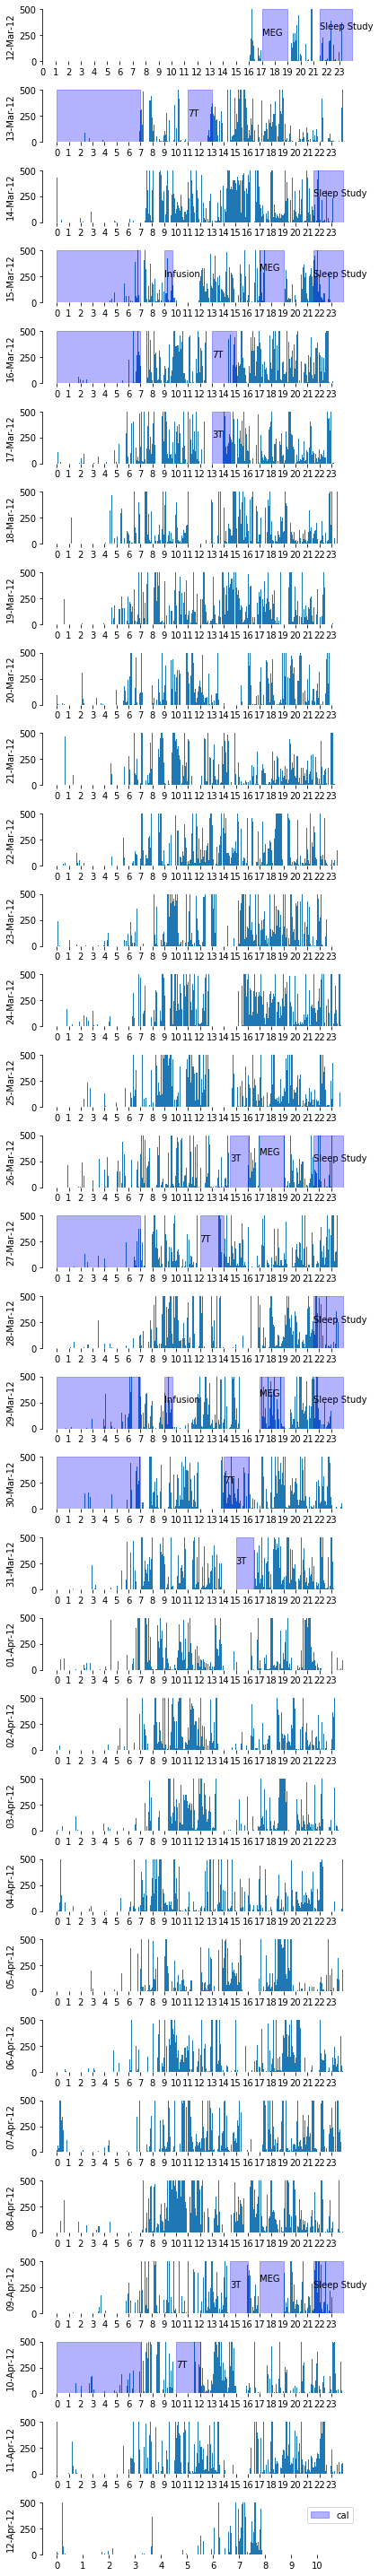

In [30]:
importlib.reload(act)

act.plot_awd(clip_dat,plots,max_act=500,show=False,comments=gc,fn_pref=os.path.join(out_dir,sub_long+'_M+logs'),plot_type='single',debug=True)


32
12-Mar-12
0 479
input 0 [-60, 180, -330]
plot this [-60, 180, -330, 479]
[0 1]
13-Mar-12
480 1919
input 0 [900, -1140, 1260]
plot this [-480, 900, -1140, 1260]
[2]
14-Mar-12
1920 3359
input 0 [-3210]
plot this [-3210, 3359]
[3]
15-Mar-12
3360 4799
input 0 [3780, -3900, 3940, -4380, 4500, -4650]
plot this [-3360, 3780, -3900, 3940, -4380, 4500, -4650, 4799]
[4 5 6]
16-Mar-12
4800 6239
input 0 [5220, -5580, 5700]
plot this [-4800, 5220, -5580, 5700]
[7]
17-Mar-12
6240 7679
input 0 [-7020, 7110]
plot this [-7020, 7110]
[8]
18-Mar-12
7680 9119
input 0 []
[]
19-Mar-12
9120 10559
input 0 []
[]
20-Mar-12
10560 11999
input 0 []
[]
21-Mar-12
12000 13439
input 0 []
[]
22-Mar-12
13440 14879
input 0 []
[]
23-Mar-12
14880 16319
input 0 []
[]
24-Mar-12
16320 17759
input 0 []
[]
25-Mar-12
17760 19199
input 0 []
[]
26-Mar-12
19200 20639
input 0 [-20070, 20160, -20220, 20340, -20490]
plot this [-20070, 20160, -20220, 20340, -20490, 20639]
[ 9 10 11]
27-Mar-12
20640 22079
input 0 [21060, -21360, 2148

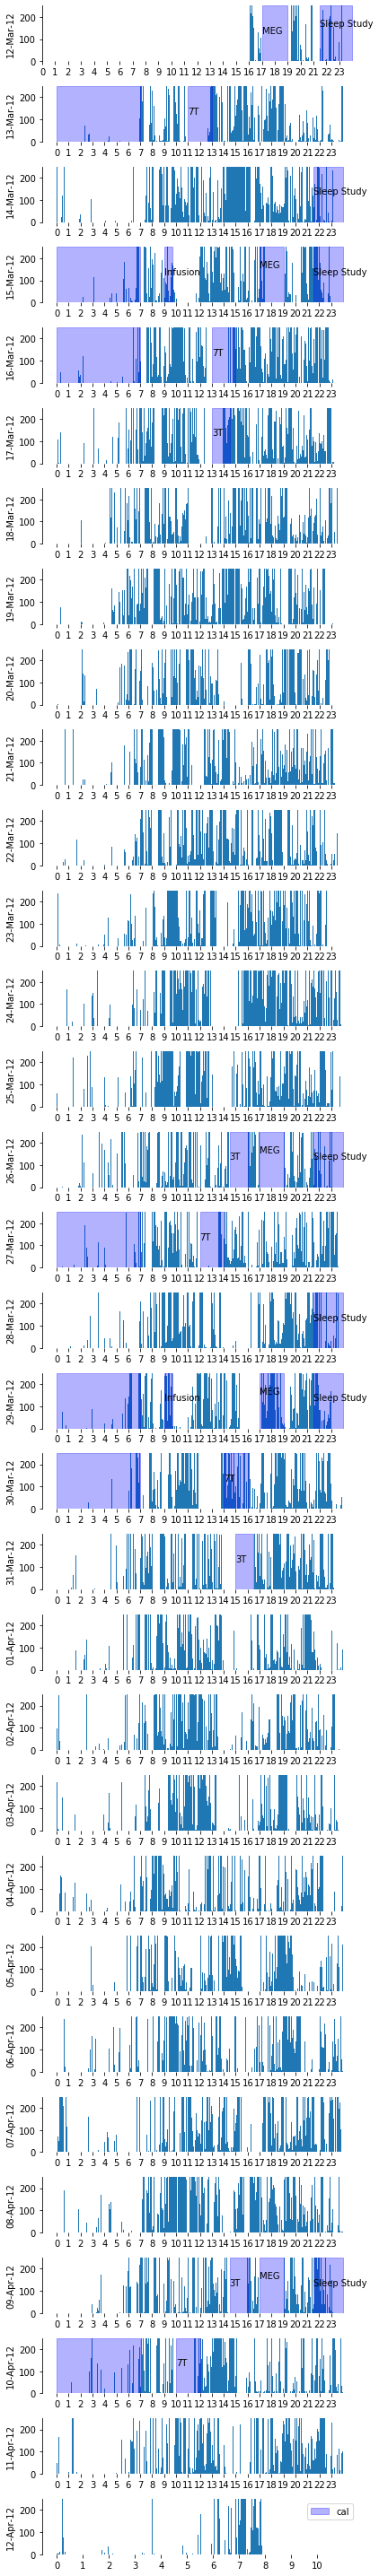

In [31]:
importlib.reload(act)

act.plot_awd(clip_dat,plots,max_act=250,show=False,comments=gc,fn_pref=os.path.join(out_dir,sub_long+'_M+logs_zoom'),plot_type='single',debug=True)


In [ ]:
      mm_dt = [ awd_dat['dt_list'][ii] for ii in mk_idx['m'] ]


In [ ]:
mm_dt

In [ ]:
mk_idx['log']

In [ ]:
clip_dat['dt_list'][542]